# Clustering on EB time course

In [ ]:
!pip install phate scprep umap-learn tasklogger magic-impute seaborn leidenalg
!pip install git+https://github.com/jacoblevine/phenograph.git

  Cloning https://github.com/jacoblevine/phenograph.git to /tmp/pip-req-build-hbyyz00_
  Running command git clone -q https://github.com/jacoblevine/phenograph.git /tmp/pip-req-build-hbyyz00_
  Created wheel for PhenoGraph: filename=PhenoGraph-1.5.2-cp38-none-any.whl size=151658 sha256=a91ef448eb089f14eb97a93fdf8765e8c4851286ab43c8eb549d64b5a8d7edb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-xlkq40c7/wheels/78/4e/51/59f41302009330e31c4a2d0dc1cbbdad17f4379471d40ab9af
Successfully built PhenoGraph


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
%matplotlib inline

import sklearn
import sklearn.cluster
import sklearn.manifold

import scprep
import os
import tasklogger
import phate
# import umap
import graphtools
import magic # pip install magic-impute
import phenograph # pip install git+https://github.com/jacoblevine/phenograph.git
import leidenalg   # louvain package is superseded by leidenalg package
# import networkx as nx
# from community import community_louvain

<a id='loading'></a>
# 1. Loading preprocessed data

In [56]:
data = pd.read_pickle("/Users/wenxinxu/Desktop/CPSC553/data/EmbryoidBody/data.pkl") 
metadata = pd.read_pickle("/Users/wenxinxu/Desktop/CPSC553/data/EmbryoidBody/metadata.pkl")

# 2. Imputation using MAGIC

As we mentioned, because scRNA-seq, suffers from dropout (the undercounting of mRNA molecules in single cells), examining expression of lowly expressed genes can be challenging. 

To overcome this, we developed a method for imputation called MAGIC (Markov Affinity Graph Imputation in Cells; [PMID: 29961576 ](https://www.ncbi.nlm.nih.gov/pubmed/29961576)). 

Without going into too much technical detail about how it works, the basic idea is that although gene expression counts in each cell are unreliable, the gene expression counts matrix contains several degrees of redundancy between genes (i.e. expression of genes is not completely independent) and among cells (i.e. we see very similar cells more than once).

A full description of MAGIC can be found in the paper, and on our website: [Denoising and imputing scRNA-seq data](https://www.krishnaswamylab.org/blog/2018/10/28/denoising-noisy-gene-expression-in-scrna-seq).

Because MAGIC returns a dense matrix (many zeros in the counts matrix are removed), we only want to keep expression of a few marker genes. 

The list in the following cell is a set of biologically relevant genes for this dataset, and we will use some of these later. 

In [45]:
marker_genes = scprep.select.get_gene_set(data, exact_word=[
    'ARID3A', 'ASCL2',  'CD34', 'CDX2', 'CER1', 'DLX1',
    'DMRT3', 'EN2', 'EOMES', 'FOXA2', 'FOXD3-AS1', 'GATA3-AS1',
    'GATA4', 'GATA5', 'GATA6-AS1', 'GBX2', 'GLI3', 'HOXA2',
    'HOXB1', 'HOXB4', 'HOXD13', 'HOXD9', 'ISL1', 'KLF5',
    'KLF7', 'LEF1', 'LHX2', 'LHX5', 'LMX1A', 'MAP2',
    'MIXL1', 'MYCBP', 'NANOG', 'NES', 'NKX2-1', 'NKX2-5',
    'NKX2-8', 'NPAS1', 'NR2F1-AS1', 'OLIG1', 'OLIG3', 'ONECUT1',
    'ONECUT2', 'OTX2', 'PAX3', 'PAX6', 'PDGFRA', 'PECAM1',
    'POU5F1', 'SATB1', 'SIX2', 'SIX3-AS1', 'SIX6', 'SOX13',
    'SOX10', 'SOX15', 'SOX17', 'SOX9', 'TTLL10', 'TAL1',
    'TBX15', 'TBX18', 'TBX5', 'TNNT2', 'WT1', 'ZBTB16',
    'ZIC2', 'ZIC5', 'ACTB', 'HAND1'])

In [46]:
data_magic = magic.MAGIC().fit_transform(data, genes=marker_genes)

Calculating MAGIC...
  Running MAGIC on 16821 cells and 17845 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 14.26 seconds.
    Calculating KNN search...
    Calculated KNN search in 27.06 seconds.
    Calculating affinities...
    Calculated affinities in 24.41 seconds.
  Calculated graph and diffusion operator in 66.29 seconds.
  Calculating imputation...
  Calculated imputation in 0.03 seconds.
Calculated MAGIC in 66.91 seconds.


In [8]:
data_magic.head()

,ACTB (ENSG00000075624),ARID3A (ENSG00000116017),ASCL2 (ENSG00000183734),CD34 (ENSG00000174059),CDX2 (ENSG00000165556),CER1 (ENSG00000147869),DLX1 (ENSG00000144355),DMRT3 (ENSG00000064218),EN2 (ENSG00000164778),EOMES (ENSG00000163508),...,TAL1 (ENSG00000162367),TBX15 (ENSG00000092607),TBX18 (ENSG00000112837),TBX5 (ENSG00000089225),TNNT2 (ENSG00000118194),TTLL10 (ENSG00000162571),WT1 (ENSG00000184937),ZBTB16 (ENSG00000109906),ZIC2 (ENSG00000043355),ZIC5 (ENSG00000139800)
AAACCGTGCAGAAA-1_Day 00-03,5.139554,0.187963,0.002828,0.001941,0.008377,0.004882,0.001405,0.016027,0.002746,0.001845,...,0.0,0.0,0.0,0.0,0.005306,0.000759,0.000000,0.142289,0.120862,0.050381
AAACGCACCGGTAT-1_Day 00-03,5.411965,0.238450,0.007822,0.000000,0.005495,0.006185,0.000000,0.002053,0.000000,0.003062,...,0.0,0.0,0.0,0.0,0.035801,0.001662,0.000000,0.000000,0.140601,0.035063
AAACGCACCTATTC-1_Day 00-03,5.217097,0.132085,0.022287,0.000000,0.010898,0.076905,0.000000,0.000183,0.000000,0.102266,...,0.0,0.0,0.0,0.0,0.024125,0.000374,0.006578,0.000119,0.079258,0.009510
AAAGATCTCTGCTC-1_Day 00-03,5.002469,0.166564,0.001413,0.007490,0.003002,0.001558,0.000337,0.041375,0.000363,0.000061,...,0.0,0.0,0.0,0.0,0.001680,0.000804,0.000000,0.187232,0.147725,0.027021
AAAGATCTGGTACT-1_Day 00-03,5.674834,0.204721,0.007214,0.000000,0.004795,0.011892,0.000000,0.001150,0.000000,0.004427,...,0.0,0.0,0.0,0.0,0.044610,0.000707,0.000000,0.000148,0.111678,0.040943


# 3. Visualizing the data

We've already spent time discussing visualizations of this data using tSNE, PHATE, and UMAP. Here, we're going to focus on PHATE, but feel free to try running another algorithm here.

In [12]:
# alternative: umap.UMAP(), sklearn.manifold.TSNE()
data_phate = phate.PHATE().fit_transform(data)

data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 16821 observations and 17845 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 13.73 seconds.
    Calculating KNN search...
    Calculated KNN search in 26.79 seconds.
    Calculating affinities...
    Calculated affinities in 1.38 seconds.
  Calculated graph and diffusion operator in 43.14 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.44 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.42 seconds.
  Calculated landmark operator in 10.67 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 4.75 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.34 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.82 seconds.
Calculated PHATE in 63.72 seconds.


/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:xlabel='PHATE1', ylabel='PHATE2'>

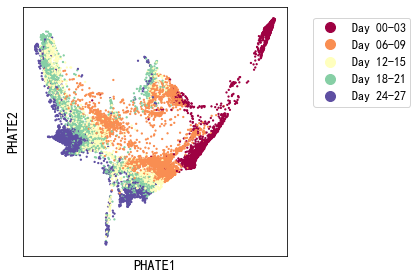

In [18]:
scprep.plot.scatter2d(data_phate, c=metadata, figsize=(6,4), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", legend_loc=(1.1, 0.6))

# 4. Clustering

## 4.1 Introduction to clustering

The goal of clustering is to identify a partition of the data such that all of the observations within each partition (called a cluster) are more similar to each other than they are to those in other clusters. 

Many clustering algorithms exist, and they each have their own quirks (just like visualization algorithms). 

`sklearn` has implementations for most popular ones and their [User Guide on Clustering](https://scikit-learn.org/stable/modules/clustering.html) is a good resource to understand general clustering approaches.

## 4.2 Clustering single cell data

we run a variety of clustering algorithms: PhenoGraph, k-means, Louvain, Spectral

In [3]:
data_pca = scprep.reduce.pca(data, n_components=50, method='dense')

n_clusters = 20

# PhenoGraph clustering
phenograph_clusters, graph, Q = phenograph.cluster(data_pca)

kmeans_clusters = sklearn.cluster.KMeans(n_clusters=n_clusters).fit_predict(data_pca)

# Louvain clustering
G = graphtools.Graph(data_pca).to_igraph() # Convert to an igraph Graph
partition = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition)
louvain_clusters = np.array(partition.membership)

# Spectral clustering
G = graphtools.Graph(data_pca).kernel
spec_op = sklearn.cluster.SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
spectral_clusters = spec_op.fit_predict(G)

### Plotting clusters with PHATE

Above, we colored our scatter plots using expression of a marker gene. However, we can use any information with one value per cell to color the plot. Here, we're using the cluster identity.

**Reordering clusters by PHATE coordinates**

By default, cluster numbers are meaningless. This makes it difficult to compare clusterings, because cluster "0" can refer to entirely different cells between runs of the same algorithm.

To enforce some consistency, we are going to reorder the clusters so that cluster "0" is always on the far right of the PHATE plot, and the highest-numbered cluster is always on the far left.

In [20]:
clusterings = {
            #    Phenograph':phenograph_clusters,
               'Louvain':louvain_clusters, 
               'KMeans':kmeans_clusters, 
               'Spectral':spectral_clusters}

clusterings = {alg: scprep.utils.sort_clusters_by_values(clusterings[alg], -data_phate.iloc[:,0]) for alg in clusterings}

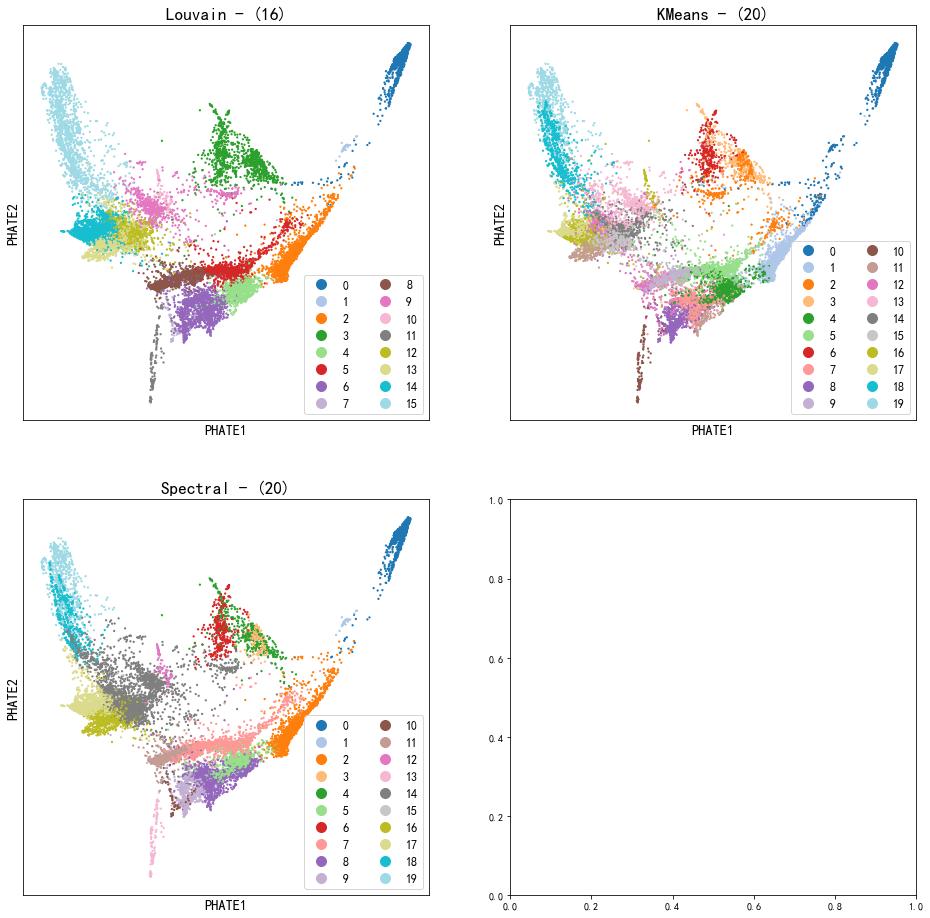

In [27]:
fig, axes = plt.subplots(2,2, figsize=(16,16))

for ax, algo in zip(axes.flatten(), clusterings):

    scprep.plot.scatter2d(data_phate, c=clusterings[algo], cmap=plt.cm.tab20,
                          title='{} - ({})'.format(algo, len(np.unique(clusterings[algo]))), 
                          ticks=False, label_prefix="PHATE", legend=True, discrete=True,
                          ax=ax)

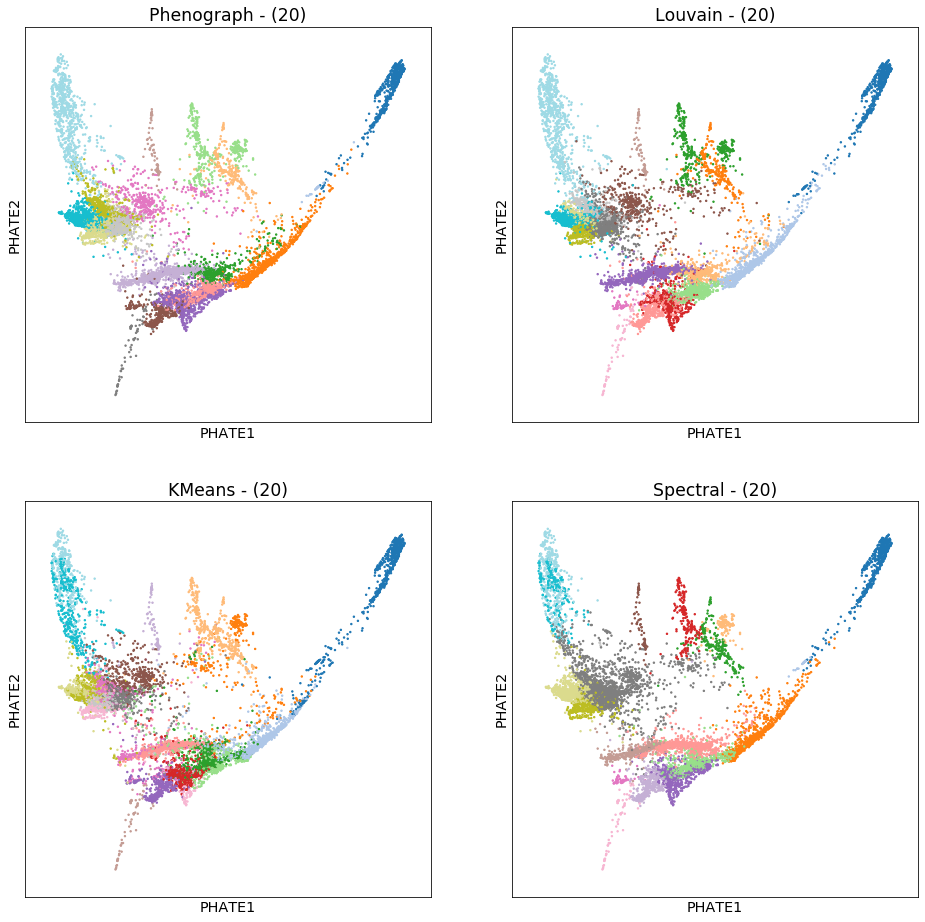

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(16,16))

for ax, algo in zip(axes.flatten(), clusterings):
    scprep.plot.scatter2d(data_phate, c=clusterings[algo], cmap=plt.cm.tab20,
                          title='{} - ({})'.format(algo, len(np.unique(clusterings[algo]))), 
                          ticks=False, label_prefix="PHATE", legend=False, discrete=True,
                          ax=ax)

### plot each cluster individually on the PHATE plot to see where they are

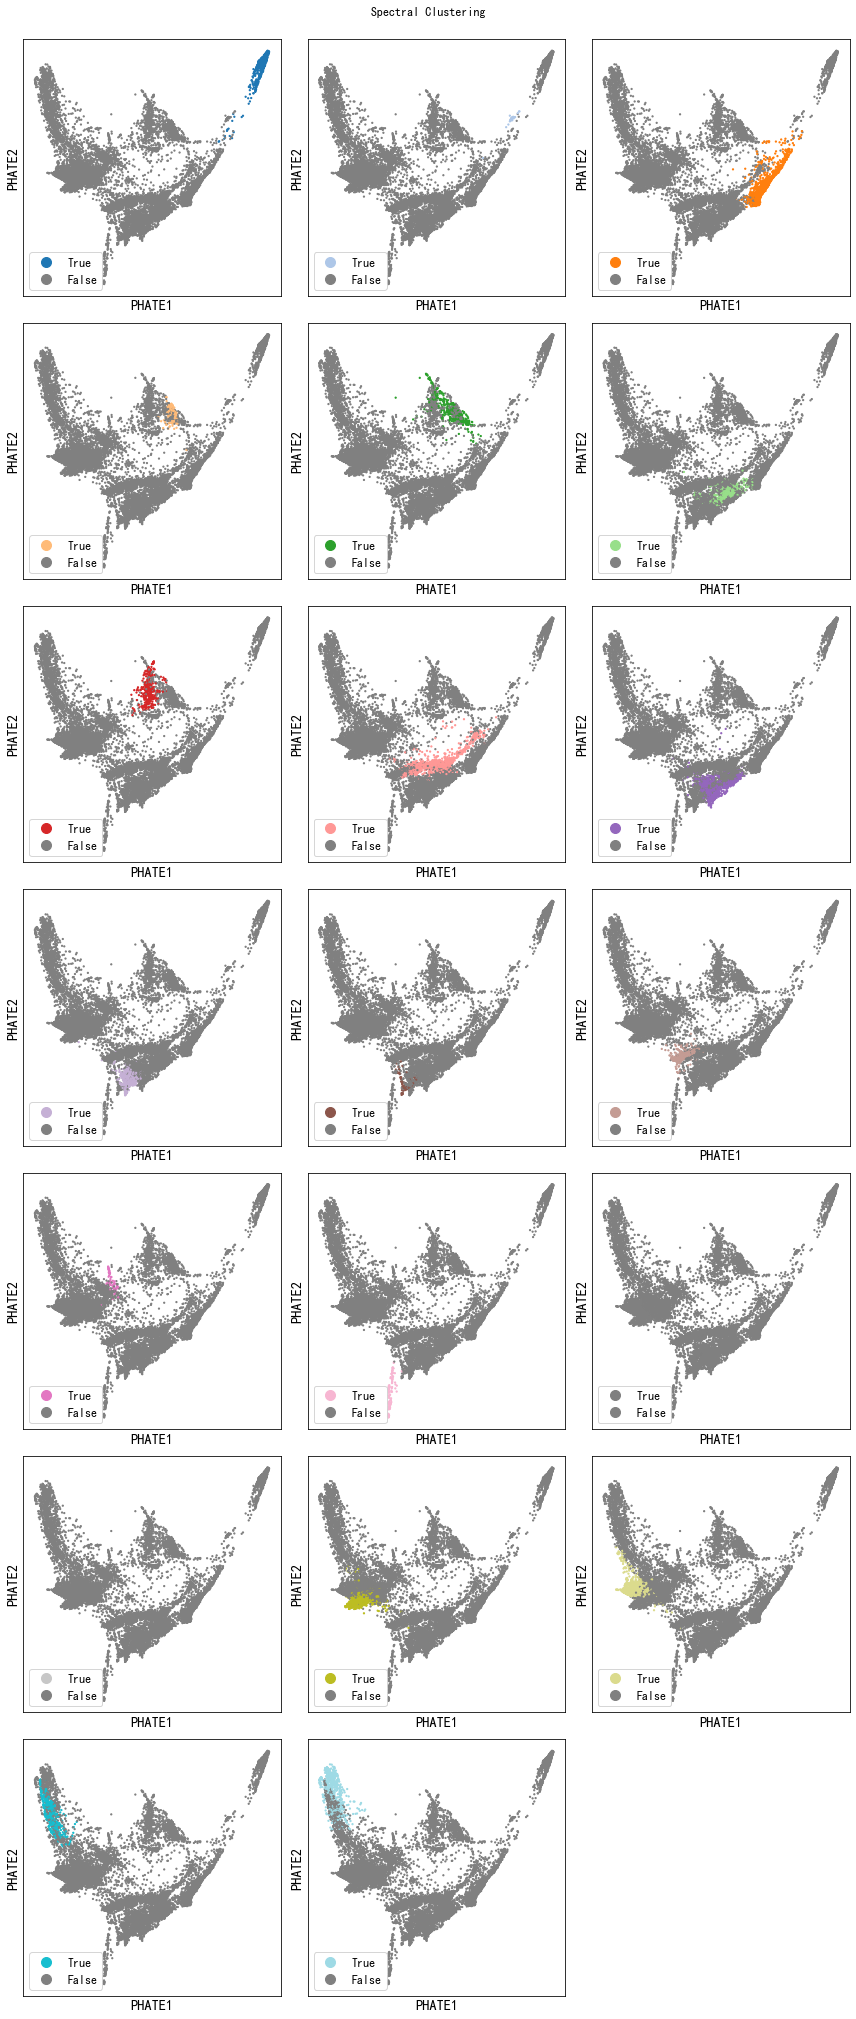

In [35]:
name = 'Spectral'
clusters = clusterings[name]

fig, axes = plt.subplots(7, 3, figsize=(12,28))
axes = axes.flatten()

for i in range(len(axes)):
    ax = axes[i]
    try:
        curr_cluster = np.unique(clusters)[i]
        curr_mask = (clusters == curr_cluster) 
        scprep.plot.scatter2d(data_phate, c=curr_mask,
                              cmap={True: plt.cm.tab20.colors[i], False: 'grey'},
                              ticks=False, label_prefix='PHATE', ax=ax, legend=True)
    except IndexError: # we have more axes than clusters
        ax.axis('off')

fig.suptitle(f'{name} Clustering', y=1)
fig.tight_layout()

### How quantitatively similar are the clustering algorithms?

We can use a metric, called the adjusted rand score, to quantify how similar any given clustering results are to each other. 

You can learn more about this metric in the `sklearn` user guide: https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-score.

This is a similarity metric, so two identical clusterings will produce a score of `1.0`. 

If every point is randomly assigned to different clusters, then the adjusted rand score will be close to `0.0`. 



Here, we're using `pdist` with a custom distance metric. 

Note, `sklearn.metrics.adjusted_rand_score` is actually a similarity metric, not a distance metric. 

So this code is not good practice and qualifies as a hack. That being said, it works.

squareform assumes diagonals will be 0, but they're actually 1 because this is a similarity metric, so we need to add 1's on the diagonal with `np.eye()`

/var/folders/hh/zr_wn8c906bfsxfyjcs6tn940000gn/T/ipykernel_72328/2539992284.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_clusterings = np.vstack(clusterings.values()) # (3, 16821)


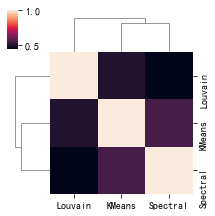

In [43]:
# Grouping all of the cluster vectors into a single array
    
all_clusterings = np.vstack(clusterings.values()) # (3, 16821)

cluster_similarities = squareform(pdist(all_clusterings, metric=sklearn.metrics.adjusted_rand_score)) + np.eye(3)

# Plot a clustermap of distances
sns.clustermap(cluster_similarities, xticklabels=clusterings.keys(), yticklabels=clusterings.keys(), figsize=(3,3))

Which cluster results are the most similar or different?

k-means and spectral are similar, while Louvain is different from the others

## 4.3 Characterizing clusters

Now, we want to characterize gene expression in each cluster to identify the cell type of that cluster. 

Cell type is easy to grasp intuitively, but hard to formalize. 

Generally, we want a cell that expresses a set of genes differently than the rest of the cells in the dataset. 

As part of writing the PHATE paper, we characterized all the cell types in this time course, and made the following fate map.

<img src="https://krishnaswamylab.github.io/img/how_to_single_cell/EB_lineage_map.png" style="height: 40rem;"/>

>Lineage tree of the EB system determined from the PHATE analysis showing embryonic stem cells (ESC), the primitive streak (PS), mesoderm  (ME), endoderm (EN), neuroectoderm (NE), neural crest (NC), neural progenitors (NP), lateral plate ME (LP ME), hemangioblast (H), cardiac (C), epicardial precursors (EP), smooth muscle precursors (SMP), cardiac precursors (CP), and neuronal subtypes (NS).

### Jitterplot

The following plot is called a [jitterplot](https://scprep.readthedocs.io/en/stable/examples/jitter.html). This plot is similar to a [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) or a [swarmplot](https://seaborn.pydata.org/generated/seaborn.swarmplot.html), but is computationally cheaper. The goal of this plot is to examine the distribution of values associated with each cell in a set of clusters.

Each point is a cell and the x-axis represents the cluster assignment of that cell. 

There's a little bit of noise added to the x-position of the cell (that's the jitter). 

The y-axis represents expression of a given gene.

You can change which gene is plotted by changing the `curr_gene` variable. All of the genes in the above plot will work.

FYI: when a gene is listed as `ZIC2/5`, this actually represents two genes: `ZIC2` and `ZIC5`.

Try running with and without MAGIC and determine which is more helpful for identifying clusters.

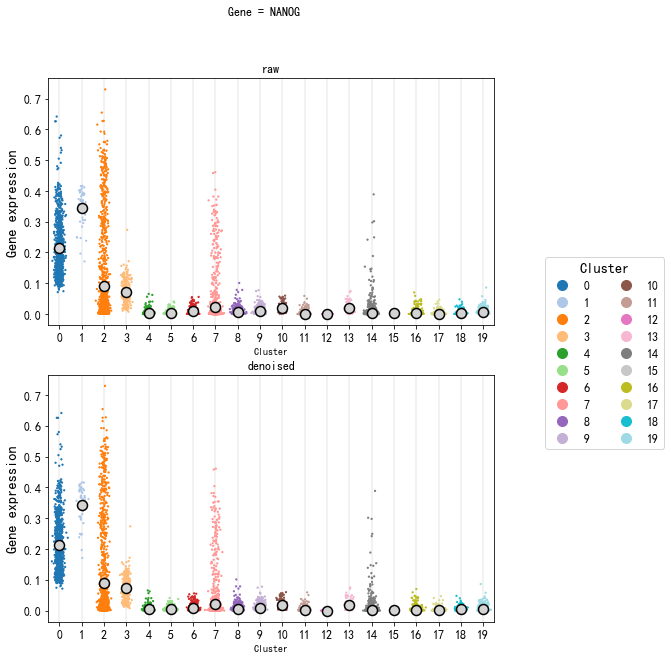

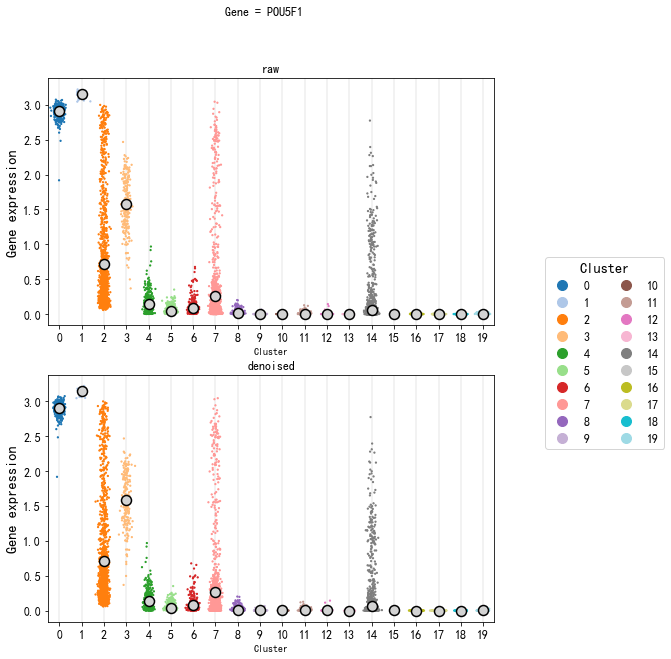

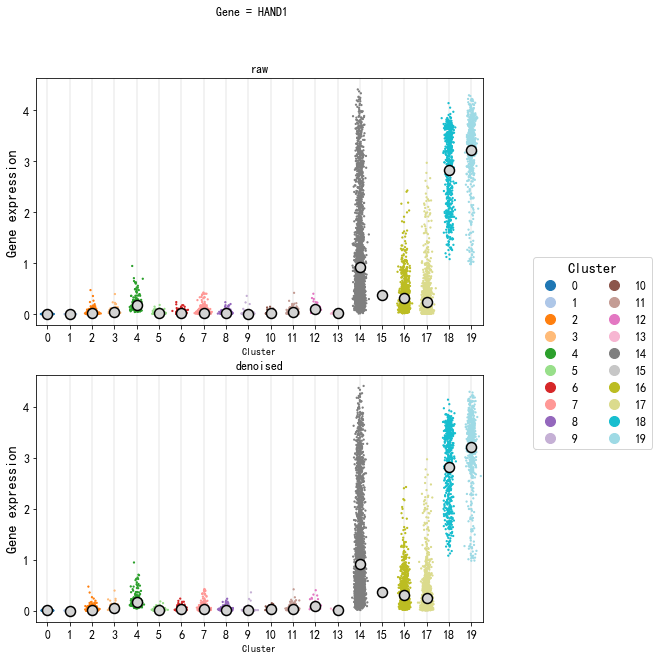

In [78]:
# choose your favorite clustering method
clusters = clusterings['Spectral']
# select a gene

for gene in ['NANOG', 'POU5F1', 'HAND1']:

    datas = {'raw': data, 'denoised': data_magic}
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))

    for i, (ax, key) in enumerate(zip(axes.flatten(), datas)):
        legend = True if i == 1 else False
        expression = scprep.select.select_cols(datas[key], exact_word=gene)
        scprep.plot.jitter(clusters, expression, c=clusters, 
                        legend=legend, legend_title='Cluster', legend_anchor=(1.1,1.5), 
                        ax=ax)

        ax.set(xlabel='Cluster', ylabel="Gene expression", title=key)
    
    fig.suptitle(f"Gene = {gene}")

#### Examining expression on PHATE

The other tool you should use for examining clusters is the PHATE plots we used above. You can change the `genes_for_plotting` list, as long as you keep it restricted to three genes.

Again change `data` to `data_magic` and determine if this makes annotating clusters easier.

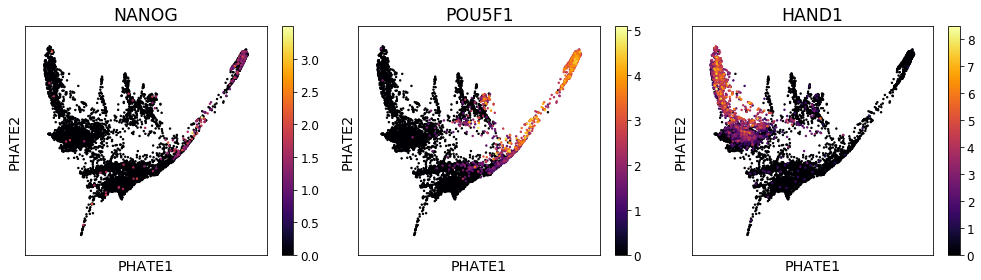

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
genes_for_plotting = ['NANOG', 'POU5F1', 'HAND1']

for curr_gene, ax in zip(genes_for_plotting, axes.flatten()):
    
    expression = scprep.select.select_cols(data, exact_word=curr_gene)
    
    sort_index = expression.sort_values().index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='PHATE', ax=ax)

fig.tight_layout()

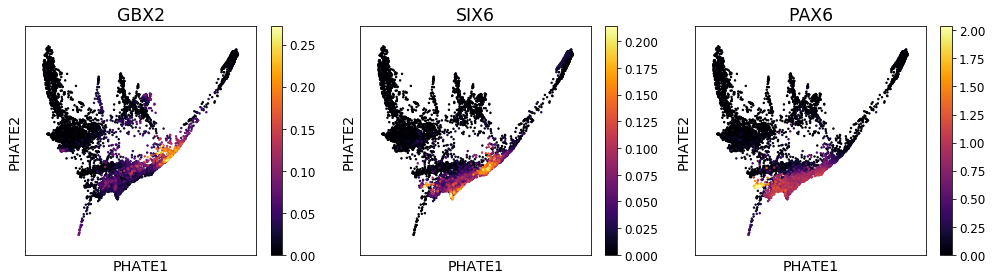

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
genes_for_plotting = ['GBX2', 'SIX6', 'PAX6']

for curr_gene, ax in zip(genes_for_plotting, axes.flatten()):
    
    expression = scprep.select.select_cols(data_magic, exact_word=curr_gene)
    
    sort_index = expression.sort_values().index
    
    scprep.plot.scatter2d(data_phate.loc[sort_index], c=expression.loc[sort_index], shuffle=False,
                         title=curr_gene, ticks=None, label_prefix='PHATE', ax=ax)

fig.tight_layout()

/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot:title={'center':'POU5F1'}, xlabel='PHATE1', ylabel='PHATE2'>

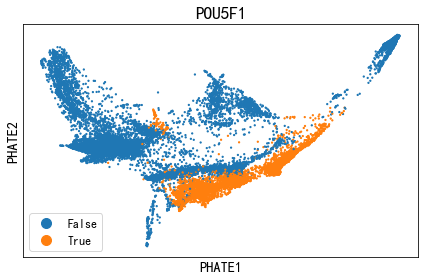

In [80]:
# cluster [2, 5, 8, 9, 12] corresponds to cell type NE-1
is_celltype = np.isin(clusters, [2, 5, 8, 9, 12])
scprep.plot.scatter2d(data_phate, c=is_celltype, shuffle=False,
                     title=curr_gene, ticks=None, label_prefix='PHATE')

### Discussion

Now, in your groups, choose a cell type from the above lineage map. Please complete the following tasks:

For the example, we use NE-1.

1. Identify which cluster corresponds to your cell type of interest.

      Clusters 8 and 9 (maybe also 2, 5, 12).

2. Create a PHATE plot that highlights your cells of interest in some way (i.e. shows them in another color). Does this plot make sense with the position of your cell type in the developmental lineage? What information can you learn about your cell type from the PHATE plot?

      Yes, this makes sense -- NC-1 is a terminal lineage. We can also learn that this cell type appears to split into two groups.

3. Open coding exercise: Create another plot that shows something interesting about your cell type. This plot should answer a biological question, for example:

      a. Is the expression of marker genes heterogeneous within your cluster?
      
      b. Are your cells present at multiple time points?
      
      c. What other genes are uniquely expressed in your cell type?

# Differential expression

In the above exercise, we manually inspected known marker genes to annotate clusters. Here, we're going to simply identify the genes that change the most between two groups. As discussed in lecture, there are several ways to calculate differential expression. We are going to focus on the mean-difference and the rank-sum statistic.

You can easily calculate basic differential expression statistics using `scprep.stats.differential_expression` and `scprep.stats.differential_expression_by_cluster`. More details about these methods can be found in the [documentation](https://scprep.readthedocs.io/en/stable/reference.html#scprep.stats.differential_expression).



In [ ]:
data_sparse = scprep.utils.SparseDataFrame(data)

In [ ]:
curr_cluster = 0
with tasklogger.log_task("t-test"):
    ttest_results = scprep.stats.differential_expression(data_sparse[clusters == curr_cluster], 
                                                         data_sparse[clusters != curr_cluster], 
                                                         measure='ttest')

Calculating t-test...
Calculated t-test in 33.96 seconds.


In [ ]:
top_genes = ttest_results['ttest'].abs().sort_values(ascending=False)[:50]

#### Print the 20 most differentially expressed genes

In [ ]:
top_genes.head(n=20)

POU5F1 (ENSG00000204531)    97.376141
MDK (ENSG00000110492)       82.153424
CD24 (ENSG00000272398)      81.051712
ZNF503 (ENSG00000165655)    80.188382
VIM (ENSG00000026025)       78.433863
MGST1 (ENSG00000008394)     76.001137
TERF1 (ENSG00000147601)     75.365581
MALAT1 (ENSG00000251562)    73.428973
COL3A1 (ENSG00000168542)    64.375682
TDGF1 (ENSG00000241186)     64.203075
SNRPN (ENSG00000128739)     61.079562
SET (ENSG00000119335)       57.778855
TMSB4X (ENSG00000205542)    56.686204
CRABP2 (ENSG00000143320)    55.593301
MEIS2 (ENSG00000134138)     55.562717
LUM (ENSG00000139329)       54.762094
COX7C (ENSG00000127184)     53.680797
HOXB2 (ENSG00000173917)     53.551586
RPS26 (ENSG00000197728)     52.987368
RPL6 (ENSG00000089009)      52.796686
Name: ttest, dtype: float64

### Plotting a histogram of gene expression in your cluster and in all other clusters

Hints:

1. Use `scprep.plot.histogram` (https://scprep.readthedocs.io/en/dev/reference.html#scprep.plot.histogram). 
 * Note, you can pass an list of expression values to get them plotted on the same axis.
 * Try using `log='y'` to get a log-scale y-axis.  When we plot on log-scale we are not changing the values themselves, but rather scaling the y-axis.  This is useful because the dynamic range of the values can be very large.
 * Use `title=` to set the title.
 * The blue / grey histogram is the first group in the list, orange is the rest.
2. Use the code from the `scprep.stats.differential_expression` to select the rows of a DataFrame in your cluster and not in your cluster.
3. The gene names are stored in `top_genes.index`. How would you select the 0th item from this index?

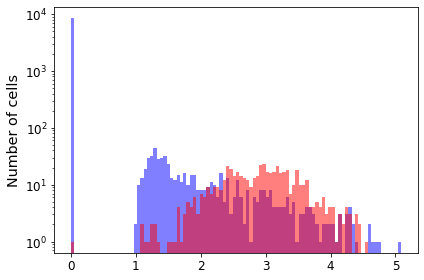

In [ ]:
# ======
# Write code to create a histogram here
curr_gene = 'POU5F1 (ENSG00000204531)'
expression_in_cluster = data_sparse.loc[clusters == curr_cluster, curr_gene]
expression_not_in_cluster = data_sparse.loc[clusters != curr_cluster, curr_gene]


scprep.plot.histogram([expression_in_cluster, expression_not_in_cluster], color=['red', 'blue'], log='y')

# ======

### Creating a heatmap of differentially expressed genes

#### Creating a heatmap using `sns.clustermap`

First, we'll do the simplest thing and create a simple `clustermap`. 

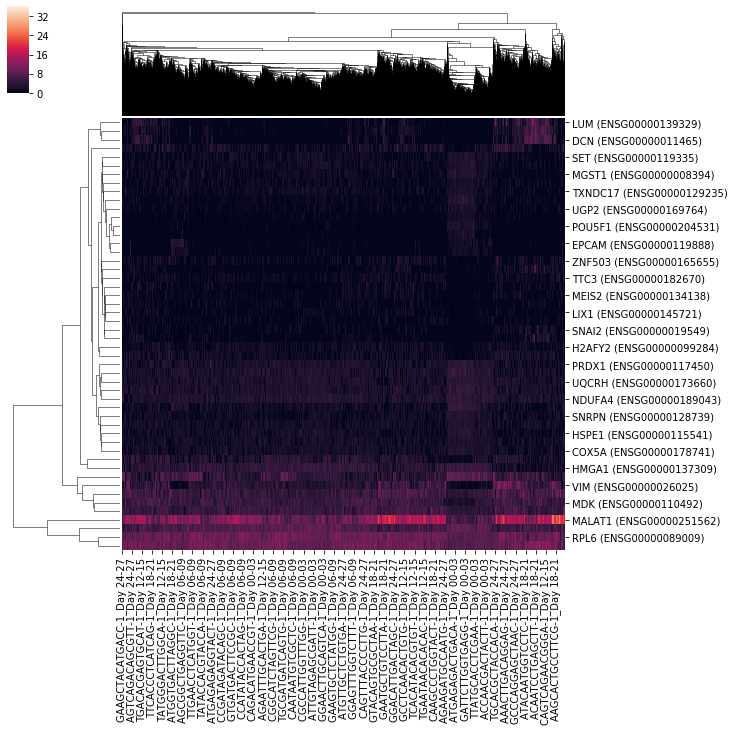

In [ ]:
sns.clustermap(data_sparse[top_genes.index].T)

#### Why does this look bad?

Notice that the ranges of expression for each gene is very different. In order to get a pretty plot, we'll need to normalize the data first.

### Z-score standardizing the data

We can easily z-score standardize the data using `sklearn.preprocessing.StandardScalar`. This will mean-center each columns of the `de_data` and set the standard deviation of each column to 1.

In [ ]:
de_data = data_sparse[top_genes.index]
de_data_zscore = sklearn.preprocessing.StandardScaler().fit_transform(de_data)

#### Generating `col_colors`

We can add colors for each column in the clustermap using a `col_colors` variable that has one RBGA or hex color per column of the data.

In [ ]:
col_colors = plt.cm.tab20(clusters)

#### Calculating color limits so the `cmap` is centered at 0

In [ ]:
lim = np.max(np.abs(de_data_zscore))

#### Generating the pretty clustermap

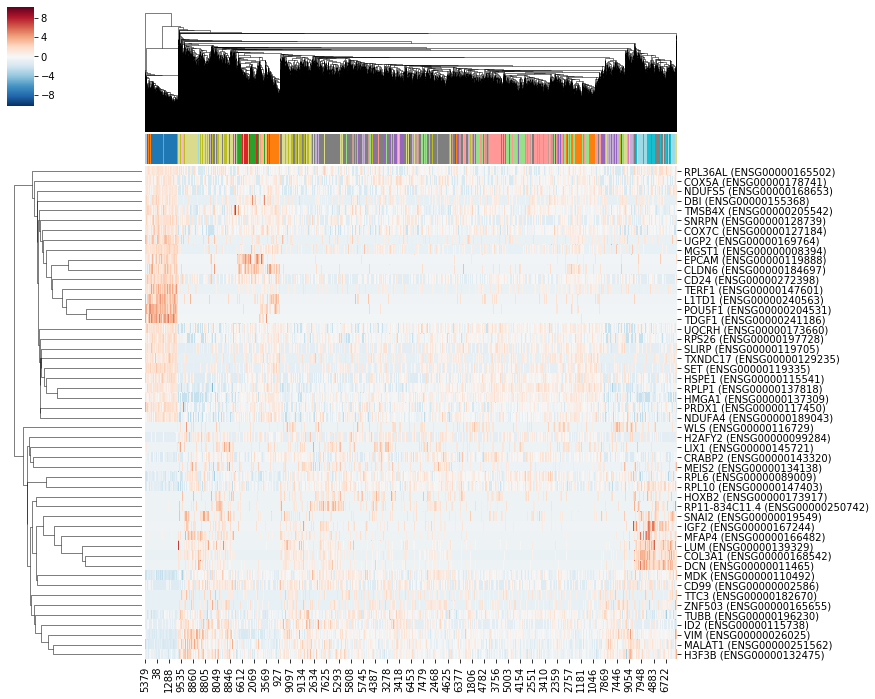

In [ ]:
cg = sns.clustermap(de_data_zscore.T, col_colors=col_colors, cmap='RdBu_r', 
                    vmin=-lim, vmax=lim, yticklabels=de_data.columns.values)

cg.ax_heatmap.figure.set_size_inches(12,12)

### Discussion

Using the clusters that you annotated in the previous exercise, perform the differential expression analysis for that cluster and generate the above heatmap and histogram. 

1. What do you notice about how uniformly each gene is expressed in each cluster?
    - Genes are frequently distinctly expressed only in one or two clusters.
2. How well does the clustermap separate your cluster from other clusters based on each individual gene?
    - It separates fairly well, though there are two groups -- probably because we combined two clusters.
3. Try plotting heatmaps for the 500-550th most DE genes or the 7000-7050 most DE genes. Try the 50 least differentially expressed genes. What do you notice about these plots compared to the ones for the most DE genes?
    - The expression here seems fairly random and fairly uniform across the whole dataset. The clusters do not separate.

In [ ]:
is_celltype = np.isin(clusters, [8, 9])

def de_test(top_genes=(0, 50)):
    ttest_results = scprep.stats.differential_expression(data_sparse[is_celltype], 
                                                         data_sparse[~is_celltype], 
                                                         measure='ttest')

    top_genes = ttest_results['ttest'].abs().sort_values(ascending=False)[top_genes[0]:top_genes[1]]

    curr_gene = 'POU5F1 (ENSG00000204531)'
    expression_in_cluster = data_sparse.loc[clusters == curr_cluster, curr_gene]
    expression_not_in_cluster = data_sparse.loc[clusters != curr_cluster, curr_gene]


    scprep.plot.histogram([expression_in_cluster, expression_not_in_cluster], color=['red', 'blue'], log='y')

    de_data = data_sparse[top_genes.index]
    de_data_zscore = sklearn.preprocessing.StandardScaler().fit_transform(de_data)

    lim = np.max(np.abs(de_data_zscore))

    cg = sns.clustermap(de_data_zscore.T, col_colors=np.where(is_celltype, 'red', 'blue'), cmap='RdBu_r', 
                        vmin=-lim, vmax=lim, yticklabels=de_data.columns.values)

    cg.ax_heatmap.figure.set_size_inches(12,12)

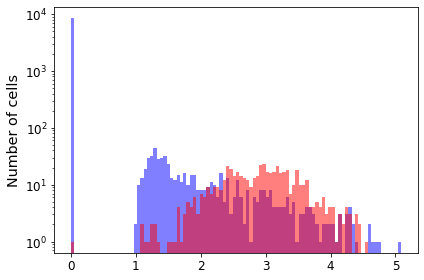

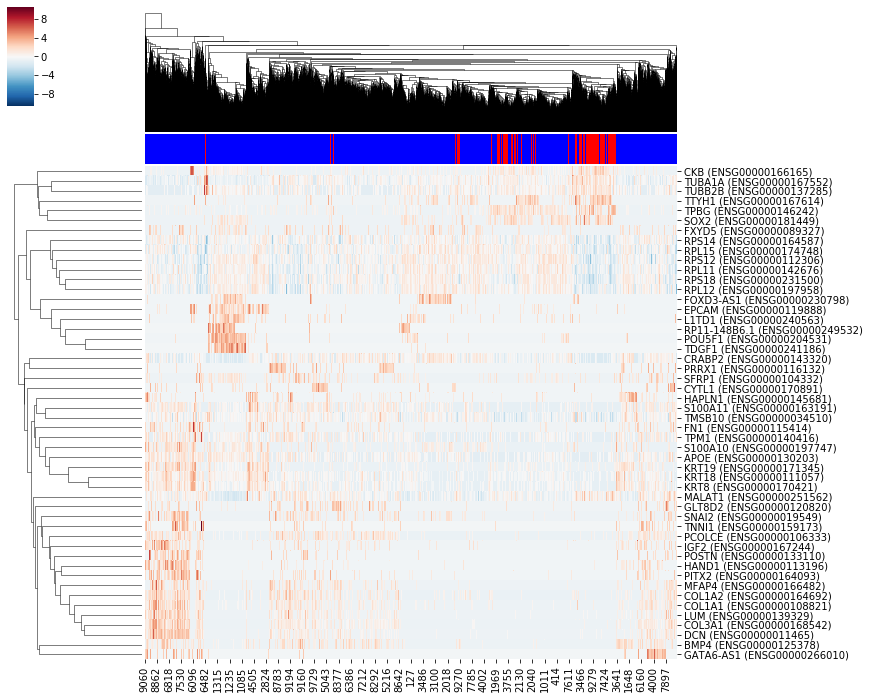

In [ ]:
de_test()

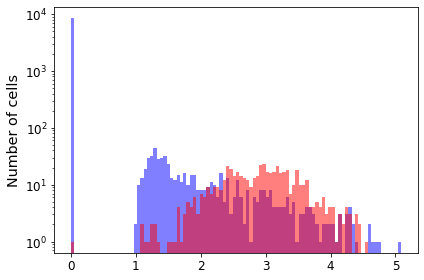

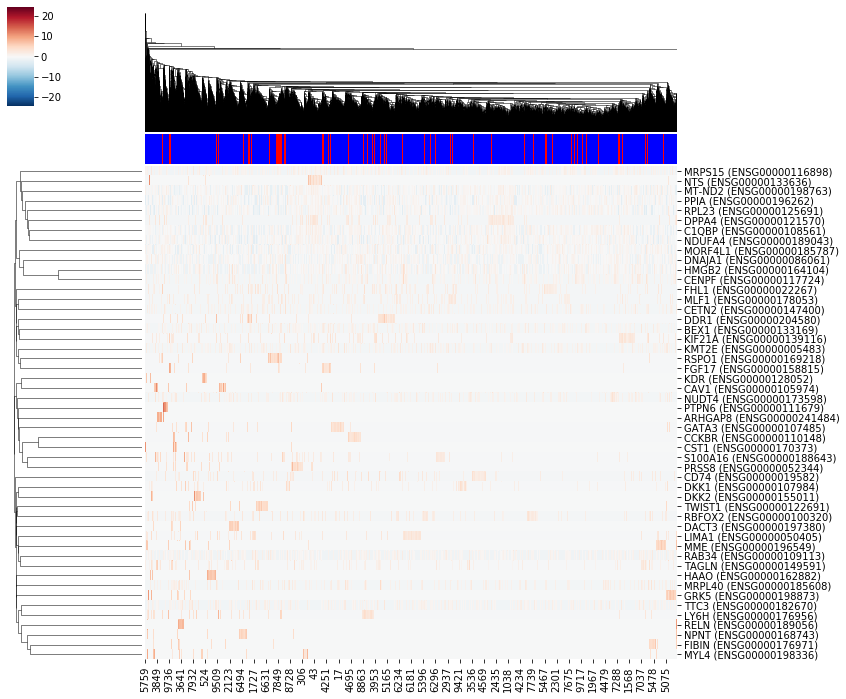

In [ ]:
de_test((500, 550))

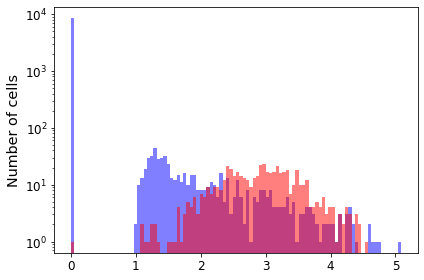

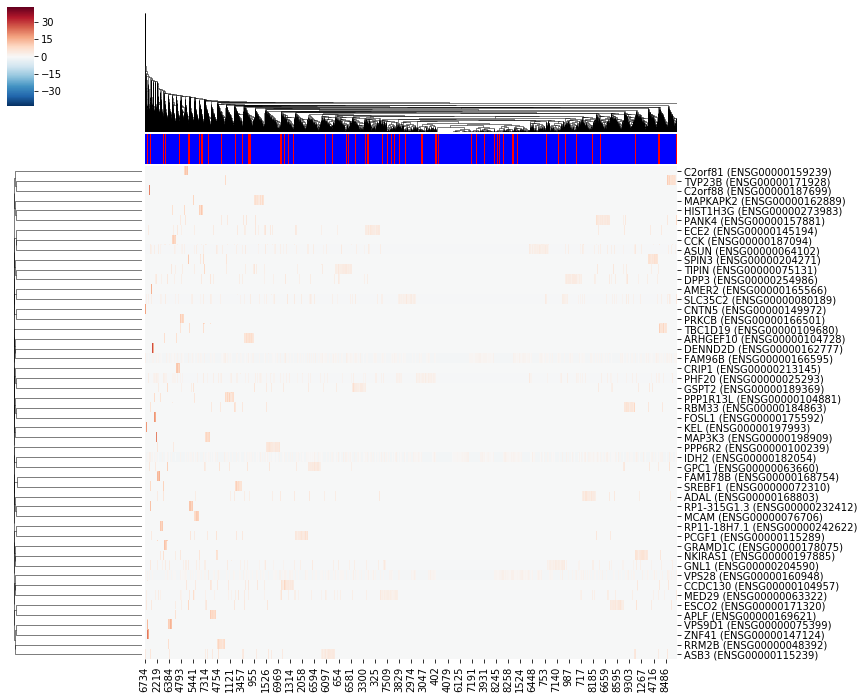

In [ ]:
de_test((7000, 7050))

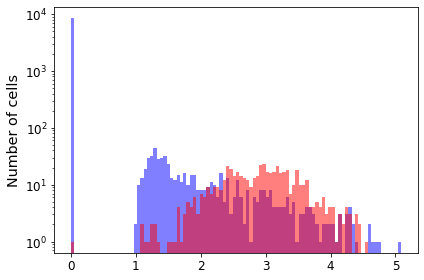

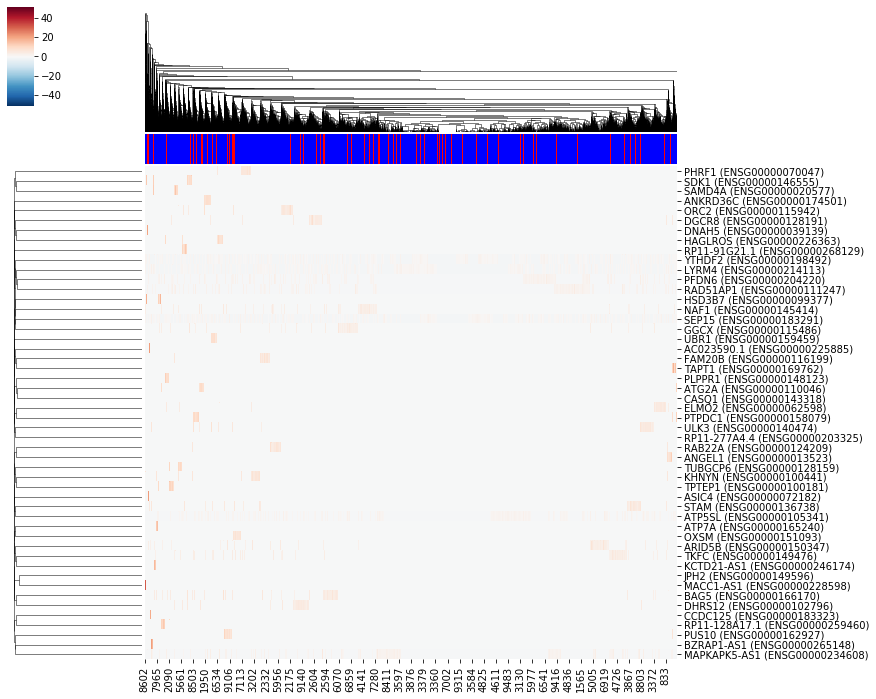

In [ ]:
de_test((data_sparse.shape[1]-50, data_sparse.shape[1]))